In [ ]:
%pip install git+https://github.com/cair/tmu.git

In [1]:
import numpy as np
import pickle

from tmu.models.autoencoder.autoencoder import TMAutoEncoder

In [2]:
def load_train_dataset(farm, event_id):
    X = np.loadtxt(f"./data_train/X_{farm}_{event_id}_10b.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)
    return X

In [3]:
def log_results(epoch, precision, recall):
    with open("results.txt", "a") as f:
        f.write(f"{epoch},{precision},{recall}\n")

In [4]:
def save_model(tm: TMAutoEncoder, filename: str):
    a, b, d, e = tm.X_train, tm.X_test, tm.encoded_X_train, tm.encoded_X_test

    tm.X_train = None
    tm.X_test = None
    tm.encoded_X_train = None
    tm.encoded_X_test = None

    with open(filename, "wb") as f:
        pickle.dump(tm, f)

    tm.X_train = a
    tm.X_test = b
    tm.encoded_X_train = d
    tm.encoded_X_test = e

In [5]:
def train(args):
    output_active = np.array([0], dtype=np.uint32)

    # TODO: Load X_train from a dataset
    X_train = load_train_dataset("C", 49)

    tm = TMAutoEncoder(
        number_of_clauses=args["num_clauses"],
        T=args["T"],
        s=args["s"],
        output_active=output_active,
        max_included_literals=args["max_included_literals"],
        accumulation=args["accumulation"],
        feature_negation=args["feature_negation"],
        platform=args["platform"],
        output_balancing=args["output_balancing"],
    )

    print(f"Starting training for {args['epochs']} epochs")

    results = {
        "precision": [],
        "recall": [],
    }

    for e in range(args["epochs"]):

        tm.fit(X_train, number_of_examples=args["number_of_examples"])

        precision = []
        recall = []

        for i in range(output_active.shape[0]):
            precision.append(tm.clause_precision(i, True, X_train, number_of_examples=500))

        results["precision"].append(precision)

        for i in range(output_active.shape[0]):
            recall.append(tm.clause_recall(i, True, X_train, number_of_examples=500))

        results["recall"].append(precision)

        # log_results(e, precision, recall)
        save_model(tm, "latest.pkl")
        print(f"Epoch: {e + 1}")

    return results


In [ ]:
args: dict = {
    "clause_weight_threshold": 0,
    "number_of_examples": 2000,
    "accumulation": 1,
    "num_clauses": 1000,
    "T": 8 * 10,
    "s": 1.5,
    "epochs": 50,
    "platform": "CPU",
    "output_balancing": 0.5,
    "max_included_literals": 32,
    "feature_negation": True,
}

result = train(args)

Starting training for 50 epochs


/opt/conda/lib/python3.11/site-packages/tmu/models/autoencoder/autoencoder.py:370: RuntimeWarning: invalid value encountered in divide
  return 1.0 * true_positive / (true_positive + false_positive)
/opt/conda/lib/python3.11/site-packages/tmu/models/autoencoder/autoencoder.py:404: RuntimeWarning: invalid value encountered in divide
  return true_positive / (true_positive + false_negative)


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46


In [57]:
def load_test_dataset(farm, event_id):
    X = np.loadtxt(f"./data_test/X_{farm}_{event_id}_10b.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)
    return X

In [58]:
X_test = load_test_dataset("C", 49)

In [59]:
tm = load_model("latest_new.pkl")

In [60]:
pred = tm.predict(X_test)

In [61]:
pred == X_test[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [62]:
mse = np.mean((pred - X_test) ** 2)
print(mse)

0.5923207912675476


2025-02-14 19:09:14,596 - numexpr.utils - INFO - Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2025-02-14 19:09:14,596 - numexpr.utils - INFO - Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-02-14 19:09:14,597 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2025-02-14 19:09:15,503 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-02-14 19:09:15,504 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-02-14 19:09:15,505 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/ma

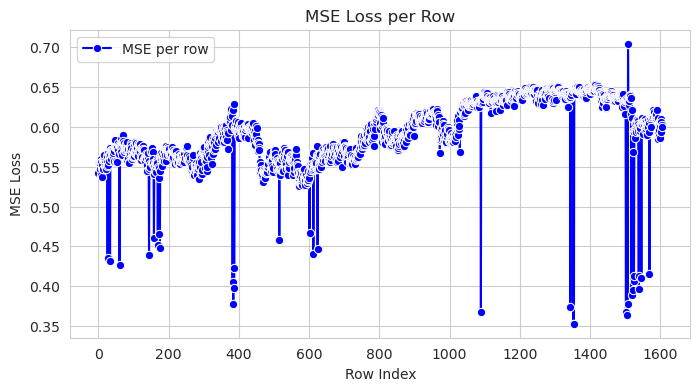

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute MSE for each row
mse_per_row = np.mean((pred - X_test) ** 2, axis=1)

# Set Seaborn style
sns.set_style("whitegrid")

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.lineplot(x=np.arange(len(mse_per_row)), y=mse_per_row, marker='o', color='b', label="MSE per row")

# Labels and title
plt.xlabel("Row Index")
plt.ylabel("MSE Loss")
plt.title("MSE Loss per Row")
plt.legend()
plt.show()


In [43]:
# Normal data: MSE = 0.49520952860529255
# Anomaly data: MSE = 